In [70]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input,Activation,BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau


import sklearn.metrics as skm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  0


In [2]:
df = pd.read_csv("../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv")
df = shuffle(df)
df.head()

,age,ethnicity,gender,img_name,pixels
1375,116,0,1,20170112213001988.jpg.chip.jpg,105 86 95 135 159 150 147 147 153 117 148 160 ...
16426,42,1,1,20170112234656696.jpg.chip.jpg,26 27 28 37 43 28 59 58 23 21 39 56 62 72 83 1...
8345,26,3,0,20170119191754105.jpg.chip.jpg,74 82 70 57 59 63 67 73 77 82 88 99 107 111 11...
9215,28,3,1,20170109131950179.jpg.chip.jpg,32 13 35 43 36 26 15 25 53 79 99 118 141 148 1...
12791,34,0,0,20170117121628625.jpg.chip.jpg,13 18 27 43 78 101 113 114 119 123 128 131 136...


In [3]:
num_pixels = len(df['pixels'][0].split(" "))
img_height = int(np.sqrt(len(df['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(df['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


In [4]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(),dtype='float32'))

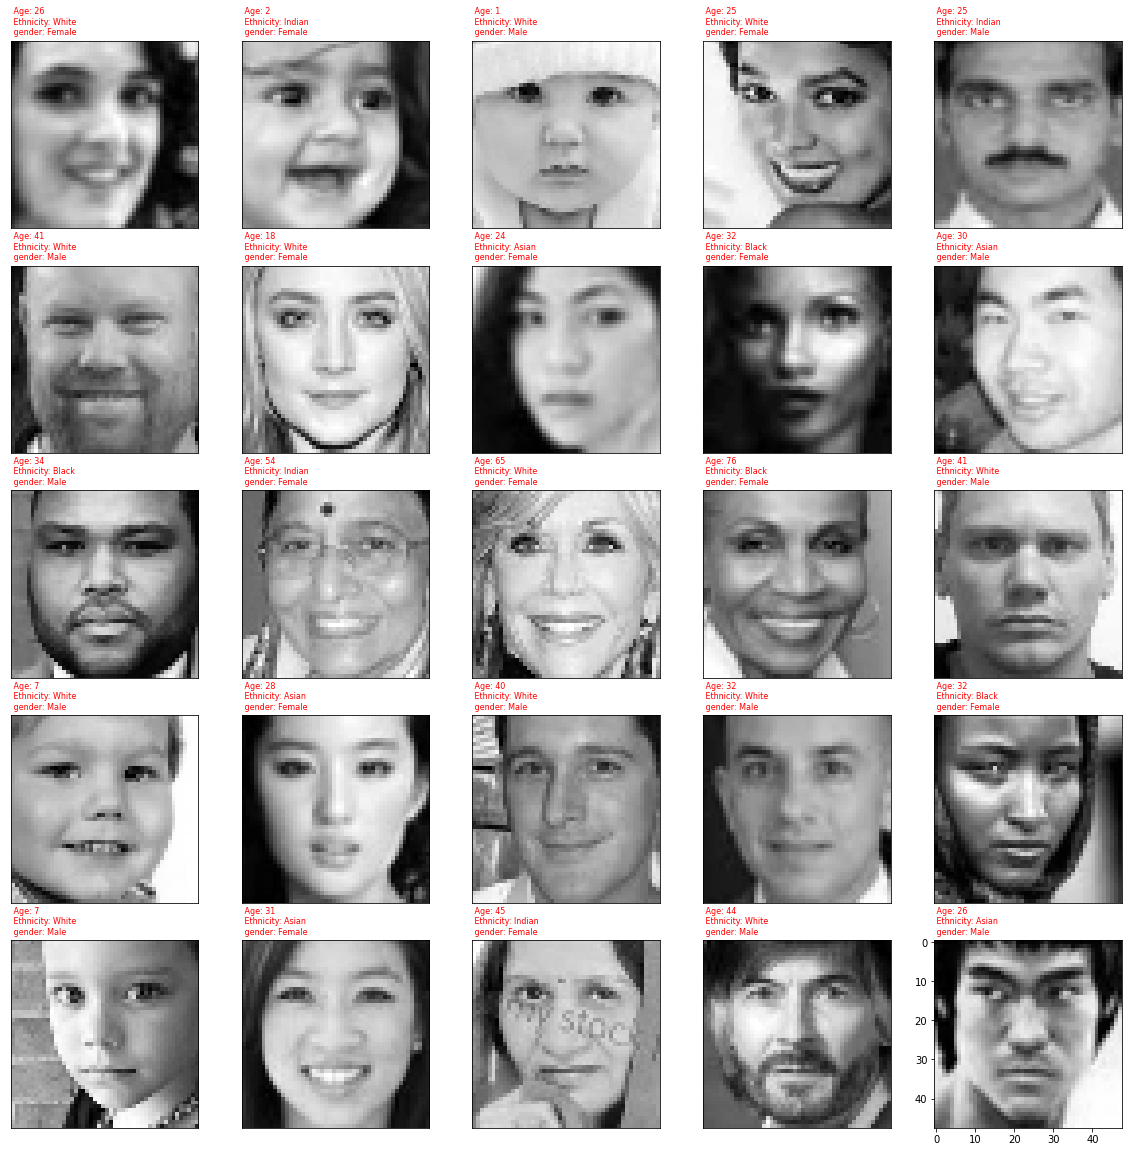

In [5]:
plt.figure(figsize=(20, 20))

for i in range(25):  
    index = np.random.randint(0, len(df))
    plt.xticks([])
    plt.yticks([])   
    plt.grid(False)
    plt.subplot(5, 5, i+1)
    plt.imshow(df['pixels'].iloc[index].reshape(48, 48),"gray")
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(df['age'].iloc[index], {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Hispanic"}[df['ethnicity'].iloc[index]], {0:"Male", 1:"Female"}[df['gender'].iloc[index]]),loc="left",color='red',fontsize = 8)

plt.show()

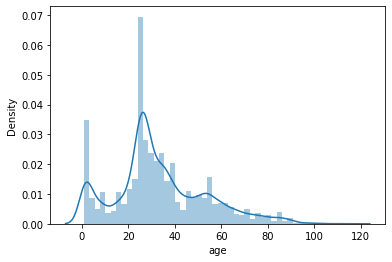

In [6]:
sns.distplot(df['age']);

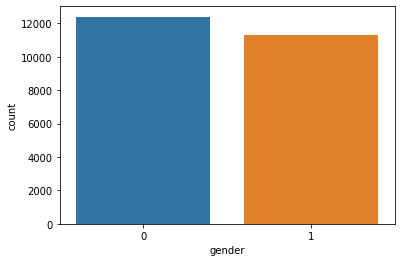

In [7]:
sns.countplot(df['gender']);

<AxesSubplot:xlabel='ethnicity', ylabel='count'>

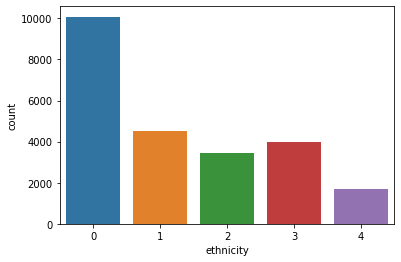

In [8]:
sns.countplot(df['ethnicity'])

In [9]:
X = np.array(df['pixels'].tolist())

In [10]:
X.shape

(23705, 2304)

In [11]:

X = np.reshape(X, (-1, 48, 48,1))
y = df[['age','gender','ethnicity']]


In [12]:
X = X/255.0

In [45]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

In [13]:
y_age=np.array(y['age'])
y_gender=np.array(y['gender'])
y_eth=np.array(y['ethnicity'])

In [14]:
input_shape=(48, 48, 1)

In [15]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(128, activation='relu') (flatten)
dense_2 = Dense(128, activation='relu') (flatten)
#dense_3 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)
#dropout_3 = Dropout(0.3) (dense_3)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)
#output_3 = Dense(1, activation='sigmoid', name='eth_out') (dropout_3)


model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

2022-10-21 01:24:18.495266: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


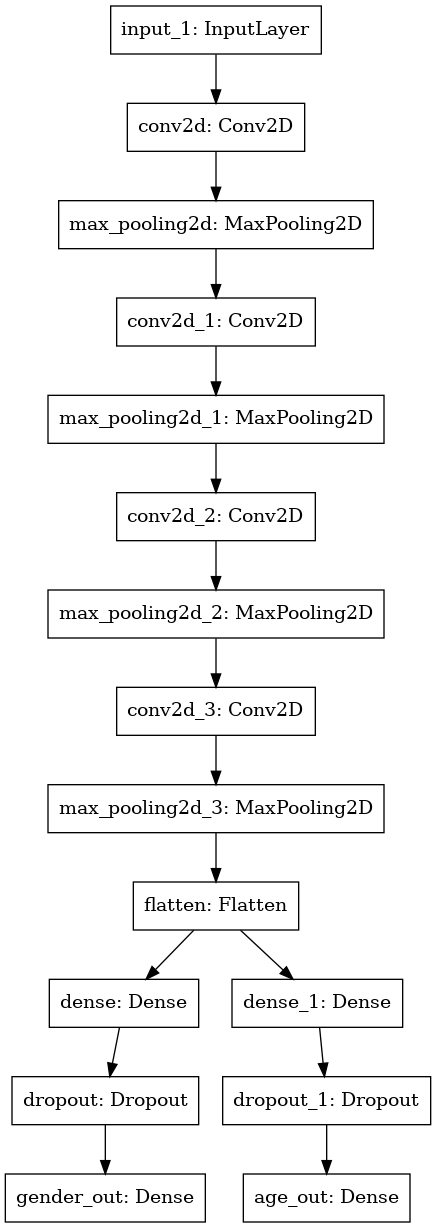

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [17]:
X.shape

(23705, 48, 48, 1)

In [18]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=50, validation_split=0.2)

2022-10-21 01:24:36.937629: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
593/593 [==============================] - 25s 40ms/step - loss: 16.2172 - gender_out_loss: 0.7226 - age_out_loss: 15.4946 - gender_out_accuracy: 0.5130 - age_out_accuracy: 0.0476 - val_loss: 14.6359 - val_gender_out_loss: 0.6899 - val_age_out_loss: 13.9460 - val_gender_out_accuracy: 0.5237 - val_age_out_accuracy: 0.0453
Epoch 2/50
593/593 [==============================] - 23s 38ms/step - loss: 14.9679 - gender_out_loss: 0.6869 - age_out_loss: 14.2811 - gender_out_accuracy: 0.5375 - age_out_accuracy: 0.0479 - val_loss: 13.9177 - val_gender_out_loss: 0.6809 - val_age_out_loss: 13.2368 - val_gender_out_accuracy: 0.5090 - val_age_out_accuracy: 0.0453
Epoch 3/50
593/593 [==============================] - 23s 39ms/step - loss: 13.5917 - gender_out_loss: 0.6260 - age_out_loss: 12.9656 - gender_out_accuracy: 0.6568 - age_out_accuracy: 0.0431 - val_loss: 11.8718 - val_gender_out_loss: 0.5885 - val_age_out_loss: 11.2833 - val_gender_out_accuracy: 0.6950 - val_age_out_accuracy: 0.034

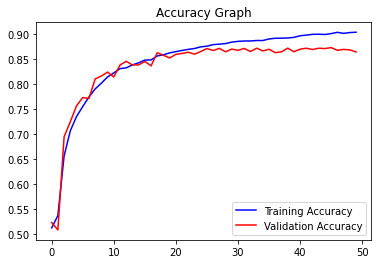

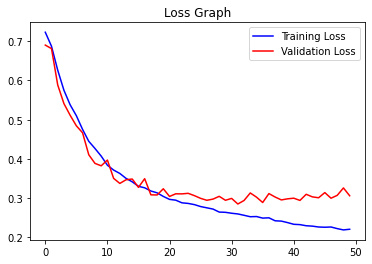

In [19]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

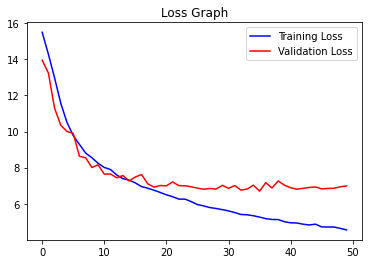

In [20]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: 1 Original Age: 2
Predicted Gender: 0 Predicted Age: 2


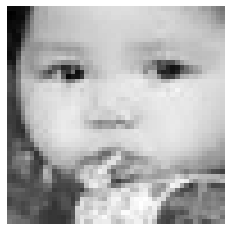

In [21]:
image_index = 100
print("Original Gender:", y_gender[image_index], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 48, 48, 1))
pred_gender = round(pred[0][0][0])
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(48, 48), cmap='gray');

Original Gender: 0 Original Age: 48
Predicted Gender: 0 Predicted Age: 49


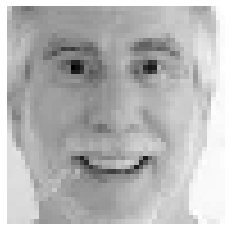

In [22]:
image_index = 777
print("Original Gender:", y_gender[image_index], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 48, 48, 1))
pred_gender = round(pred[0][0][0])
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(48, 48), cmap='gray');

Original Gender: 1 Original Age: 61
Predicted Gender: 1 Predicted Age: 69


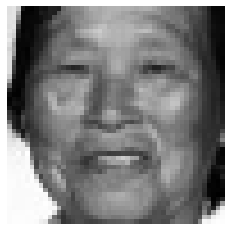

In [23]:
image_index = 666
print("Original Gender:", y_gender[image_index], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 48, 48, 1))
pred_gender = round(pred[0][0][0])
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(48, 48), cmap='gray');

In [ ]:

X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X, y_eth, test_size=0.3, random_state=44)

In [ ]:
train_generator_ethnicity =train_datagen.flow(
    X_train_ethnicity ,y_train_ethnicity ,batch_size=64
)

test_generator_ethnicity =test_datagen.flow(
    X_test_ethnicity ,y_test_ethnicity ,batch_size=64
)

In [31]:
model_ethnicity = Sequential()

model_ethnicity.add(Conv2D(16,(3,3), padding='same',activation='relu',input_shape=(48,48,1)))
model_ethnicity.add(MaxPooling2D(2,2))

model_ethnicity.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model_ethnicity.add(MaxPooling2D(2,2))

model_ethnicity.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model_ethnicity.add(MaxPooling2D(2,2))


model_ethnicity.add(Flatten())
model_ethnicity.add(Dense(128,activation='relu'))


model_ethnicity.add(Dense(5,activation='softmax'))

model_ethnicity.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_ethnicity.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

In [ ]:
model_ethnicity.fit(
    train_generator_ethnicity, 
    epochs= 10,
    validation_data= test_generator_ethnicity,
    callbacks= callbacks
)

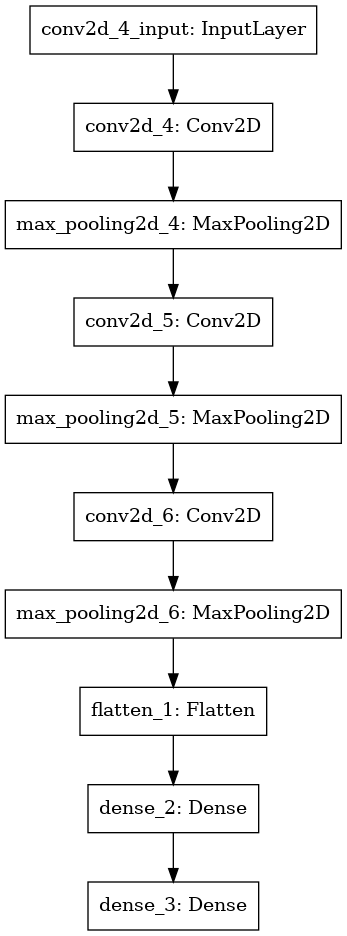

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model_ethnicity)

In [32]:
history_eth = model_ethnicity.fit(x=X, y=y_eth, batch_size=64, epochs=15, validation_split=0.3)

Epoch 1/15
260/260 [==============================] - 11s 42ms/step - loss: 1.1453 - accuracy: 0.5638 - val_loss: 0.9061 - val_accuracy: 0.6774
Epoch 2/15
260/260 [==============================] - 11s 42ms/step - loss: 0.8370 - accuracy: 0.7047 - val_loss: 0.8827 - val_accuracy: 0.6860
Epoch 3/15
260/260 [==============================] - 10s 39ms/step - loss: 0.7475 - accuracy: 0.7372 - val_loss: 0.7530 - val_accuracy: 0.7447
Epoch 4/15
260/260 [==============================] - 10s 39ms/step - loss: 0.6955 - accuracy: 0.7592 - val_loss: 0.7414 - val_accuracy: 0.7462
Epoch 5/15
260/260 [==============================] - 11s 42ms/step - loss: 0.6433 - accuracy: 0.7754 - val_loss: 0.7319 - val_accuracy: 0.7514
Epoch 6/15
260/260 [==============================] - 10s 39ms/step - loss: 0.6034 - accuracy: 0.7899 - val_loss: 0.6905 - val_accuracy: 0.7639
Epoch 7/15
260/260 [==============================] - 11s 41ms/step - loss: 0.5654 - accuracy: 0.8014 - val_loss: 0.6948 - val_accuracy:

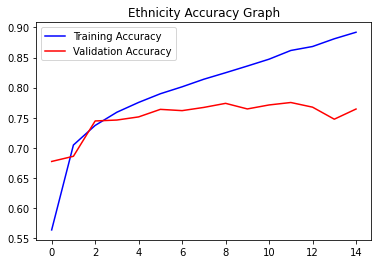

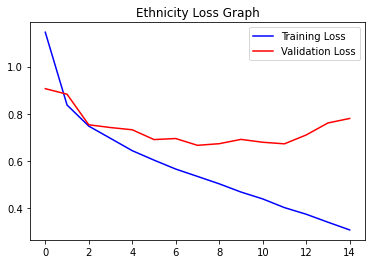

In [33]:
# plot results for gender
acc = history_eth.history['accuracy']
val_acc = history_eth.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Ethnicity Accuracy Graph')
plt.legend()
plt.figure()

loss = history_eth.history['loss']
val_loss = history_eth.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Ethnicity Loss Graph')
plt.legend()
plt.show()

In [34]:
test_sample=np.array(pd.Series(np.arange(X.shape[0])).sample(frac=0.2))

In [35]:
X_test=X[test_sample]
pred = model.predict(X_test.reshape(X_test.shape[0], 48, 48, 1))

In [39]:
pred_eth=model_ethnicity.predict(X_test.reshape(X_test.shape[0], 48, 48, 1))

In [36]:
y_test_age=y_age[test_sample]
y_test_gender=y_gender[test_sample]
y_test_eth=y_eth[test_sample]

In [60]:
pred_gender=[round(pred[0][x][0]) for x in range(X_test.shape[0])]

In [58]:
pred_age=[round(pred[1][x][0]) for x in range(X_test.shape[0])]

In [46]:
pred_eth=[np.argmax(pred_eth[x]) for x in range(X_test.shape[0])]

In [61]:
Error_m=pd.DataFrame(columns=['MedAE','MAE','MSE','R2S'])
Error_m.loc['CNN_Age','MedAE']=skm.median_absolute_error(y_test_age, pred_age)
Error_m.loc['CNN_Age','MAE']=skm.mean_absolute_error(y_test_age, pred_age)
Error_m.loc['CNN_Age','MSE']=np.sqrt(skm.mean_squared_error(y_test_age, pred_age))
Error_m.loc['CNN_Age','R2S']=skm.r2_score(y_test_age, pred_age)
Error_m.loc['CNN_gender','MedAE']=skm.median_absolute_error(y_test_gender, pred_gender)
Error_m.loc['CNN_gender','MAE']=skm.mean_absolute_error(y_test_gender, pred_gender)
Error_m.loc['CNN_gender','MSE']=np.sqrt(skm.mean_squared_error(y_test_gender, pred_gender))
Error_m.loc['CNN_gender','R2S']=skm.r2_score(y_test_gender, pred_gender)
Error_m.loc['CNN_ethnicity','MedAE']=skm.median_absolute_error(y_test_eth, pred_eth)
Error_m.loc['CNN_ethnicity','MAE']=skm.mean_absolute_error(y_test_eth, pred_eth)
Error_m.loc['CNN_ethnicity','MSE']=np.sqrt(skm.mean_squared_error(y_test_eth, pred_eth))
Error_m.loc['CNN_ethnicity','R2S']=skm.r2_score(y_test_eth, pred_eth)

Error_m

,MedAE,MAE,MSE,R2S
CNN_Age,3.0,4.305843,6.412884,0.894761
CNN_gender,0.0,0.095339,0.308769,0.618565
CNN_ethnicity,0.0,0.328834,1.004,0.449334


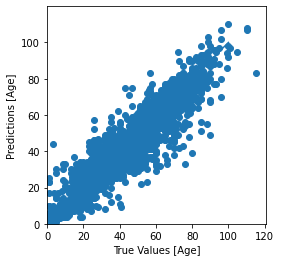

In [71]:
plt.scatter(y_test_age, pred_age)
plt.xlabel('True Values [Age]')
plt.ylabel('Predictions [Age]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [75]:
confusion_matrix(y_test_gender, pred_gender)

array([[2176,  229],
       [ 223, 2113]])

In [76]:
confusion_matrix(y_test_eth, pred_eth)

array([[1786,   24,   27,   68,   70],
       [  34,  812,    7,   35,   22],
       [  25,    9,  632,   15,    8],
       [  48,   15,   12,  715,   25],
       [ 104,    9,   15,   46,  178]])

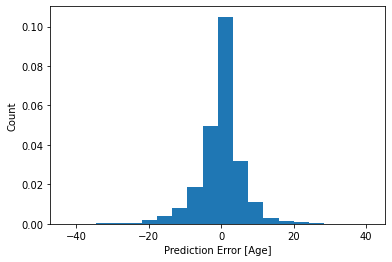

In [68]:
error = pred_age - y_test_age
plt.hist(error, bins = 20, density=True)
plt.xlabel("Prediction Error [Age]")
_ = plt.ylabel("Count")